In [1]:
from ceo import constants, StopWatch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

/home/ubuntu/CEO/python/ceo/zemax


# WFPT model demo with a SH48
This demo shows how to use the Wide Field Phasing Testbed (WFPT) model developed in CEO, using a single on-axis SH48 WFS.

Developed by: F. Quiros-Pacheco (GMTO)

Last update: 16/03/2022

## Initialize WFPT model
The WFPT package is located in **~/CEO/python/ceo/wfpt/** . There are so far three WFPT classes:
1. **wfpt_testbed**. The main WFPT testbed class that enables ray tracing through the WFPT Zemax model imported in CEO.
2. **wfpt_source**. The class that emulates the illumination source. It contains a "rays bundle" object to raytrace through the WFPT model, and a "CEO Source" object to enable WF propagation from the exit pupil of the WFPT testbed to the WFS. Currently only on-axis propagation possible.
3. **wfpt_sh48**. A wrapper class for the "CEO ShackHartmann" class that implements the SH48 model.

In [2]:
from ceo import wfpt_testbed, wfpt_source, wfpt_sh48
from ceo import wfpt_visulib as visu

In [3]:
#----------------- WFPT model -----------------------------------
M2_baffle_diam=3.6  # size of M2 baffle
project_truss_onaxis=True # simulate truss shadows over central segment

wfpt = wfpt_testbed(M2_baffle_diam=M2_baffle_diam, project_truss_onaxis=project_truss_onaxis)

#### SH48 model parameters
The AGWS SH48 features 48 sub-apertures across the diameter. Each sub-aperture is sampled with 8$\times$8 camera pixels. The pixel scale is 0.40 arcsec.

The SH48 model is realized as follows. The wavefront on each sub-aperture is sampled with 16$\times$16 pixels <span style="font-family:Courier">(N_PX_LENSLET = 16)</span>. For Nyquist sampling of the SH spot in the focal plane <span style="font-family:Courier">(DFT_osf = 2)</span>, the wavefront on each sub-aperture is inserted into a 32$\times$32 zero-padded complex amplitude array <span style="font-family:Courier">(DFT_osf $\cdot$ N_PX_LENSLET)</span>. This array is then Fourier transformed (still 32$\times$32 pixels), and cropped to 24$\times$24 pixels <span style="font-family:Courier">(N_PX_IMAGE = 24)</span>. The resulting SH spot (squared modulus of the FT) is binned by a factor 3 <span style="font-family:Courier">(BIN_IMAGE = 3)</span> to get the final 8$\times$8 spot image on the detector.

The final pixel scale is: $\lambda\cdot$BIN_IMAGE / (DFT_osf$\cdot d$) where $\lambda$ is the SH central wavelength, and $d$ is the size of the sub-aperture [m].

In [4]:
#---------------- SH and SH source parameters --------------------

#-- GMT AGWS SH48 design parameters
D_GMT = 25.4  #  GMT pupil diameter [m]
SH48_N_LENSLET = 48 # linear number of AGWS SH48 sub-apertures across GMT diameter
SH48_LENSLET_SIZE = D_GMT/SH48_N_LENSLET  # size of SH48 sub-aperture [m]

#-- WFPT model parameters to ensure proper SH sampling of GMT pupil.
sh_L = 27.31 # rays box size [m]. The GMT pupil is contained in this box. Value provided by R. Conan.
N_SIDE_LENSLET = round(sh_L / SH48_LENSLET_SIZE)  # number of SAs across the box.
LENSLET_SIZE = sh_L / N_SIDE_LENSLET
print("Size of SA by design:    %0.3f m"%SH48_LENSLET_SIZE)
print("Size of SA in the model: %0.3f m"%LENSLET_SIZE)

Size of SA by design:    0.529 m
Size of SA in the model: 0.525 m


In [5]:
#-- SH simulation parameters to realize proper pixel scale.
N_PX_LENSLET = 16
DFT_osf = 2
N_PX_IMAGE = 24
BIN_IMAGE = 3
sh_nPx = N_SIDE_LENSLET * N_PX_LENSLET + 1 # pixels across sh_L

#--  Photometry parameters
sh_band = 'R+I'
sh_mag = 10

#----------------- SH Source model ------------------------------
src = wfpt_source(sh_band, sh_nPx, sh_L, mag=sh_mag)

#----------------- SH model -------------------------------------
wfs = wfpt_sh48(N_SIDE_LENSLET=N_SIDE_LENSLET, N_PX_LENSLET=N_PX_LENSLET, d=LENSLET_SIZE,
               DFT_osf=DFT_osf, N_PX_IMAGE=N_PX_IMAGE, BIN_IMAGE=BIN_IMAGE)

wfs_pxscl = src.wavelength * BIN_IMAGE / (DFT_osf * LENSLET_SIZE) * constants.RAD2ARCSEC
print("Desired pixel scale:  0.400 arcsec")
print("Obtained pixel scale: %0.3f arcsec"%wfs_pxscl)

Desired pixel scale:  0.400 arcsec
Obtained pixel scale: 0.421 arcsec


## Propagate a flat wavefront and do calibrations
Activate the keyword **keep_rays_for_plot** if you want to show a ray diagram. Otherwise, set it to *False* to speed up the ray tracing.

In [6]:
keep_rays_for_plot = True

In [7]:
%%time
src.reset()
wfpt.reset()
wfpt.propagate(src, keep_rays_for_plot=keep_rays_for_plot)
opd0 = src._gs.phase.host()

CPU times: user 1.18 s, sys: 880 ms, total: 2.06 s
Wall time: 2.07 s


### Show the WF at the exit pupil

on-axis WFE: 305.8 nm RMS


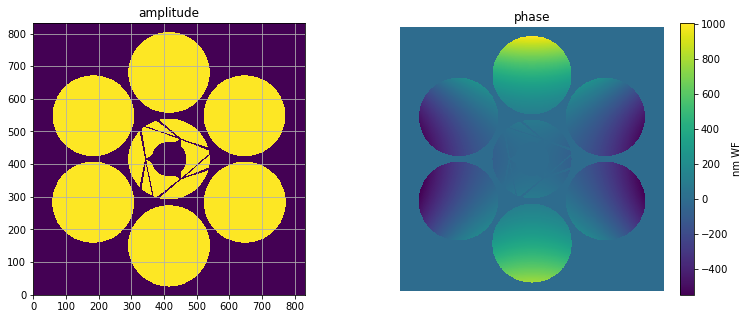

In [8]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))

ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_title('amplitude')
ax1.set_aspect('equal')
ax1.grid()

visu.show_wavefront(opd0*1e9, clb_label='nm WF', title='phase', fig=fig, ax=ax2)
print("on-axis WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))

### Show the rays diagram

In [9]:
if keep_rays_for_plot:
    xyz,klm,sid = wfpt.rays_data
    vig = src.rays.vignetting.host().ravel()>0

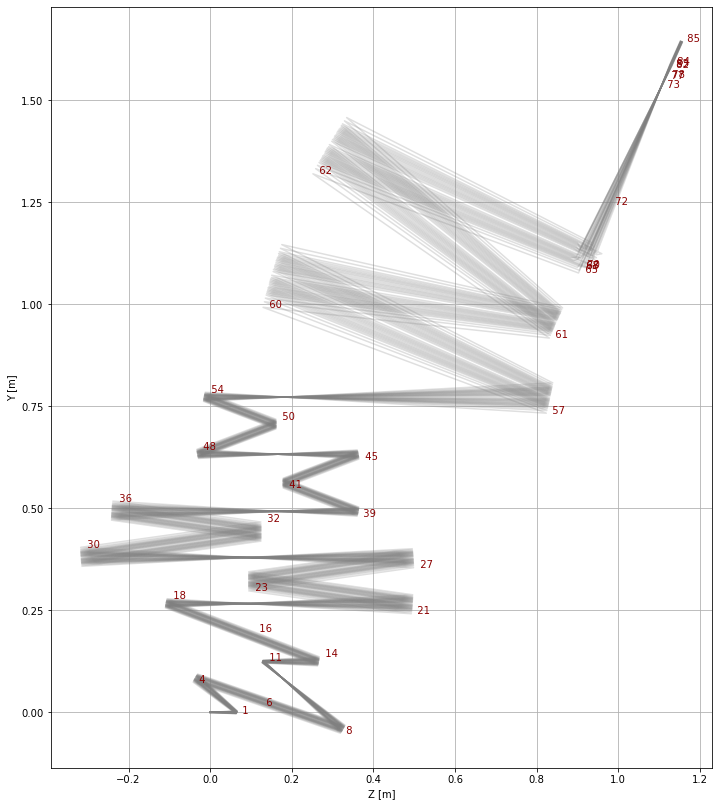

In [10]:
if keep_rays_for_plot:
    visu.show_rays(xyz, klm, sid, vig)

### SH48 Calibration
The calibration of the SH48 needs to be done with an extended source. Set the parameter **src.fwhm** to define an extended source, where **src.fwhm** is the fwhm of the source intensity distribution in detector pixel unit (before binning).

#### Determine under-sampling factor
The under-sampling factor is defined as the ratio between the actual pixel scale of the sensor and the theoretical Nyquist sampling of the diffraction-limited SH spot.

In [11]:
subap_dl_fwhm = (src.wavelength / LENSLET_SIZE) * constants.RAD2ARCSEC
print('subaperture size: %0.3f m'%LENSLET_SIZE)
print("FWHM of DL spot:  %0.3f arcsec"%(subap_dl_fwhm))
print("SH48 pixel scale: %0.3f arcsec"%(wfs.camera.pixelScaleArcsec(src._gs)))

sh_undersampling_factor = wfs_pxscl / (0.5 * subap_dl_fwhm)
print("SH48 undersampling factor: %0.1f"%sh_undersampling_factor)

subaperture size: 0.525 m
FWHM of DL spot:  0.281 arcsec
SH48 pixel scale: 0.421 arcsec
SH48 undersampling factor: 3.0


#### Calibrate SH48 with extended source
The SH calibrate method computes:
1. The valid sub-aperture set (based on selected illumination threshold);
2. The reference slope vector.

SH source FWHM: 0.842 arcsec
Total SH valid sub-apertures: 1230


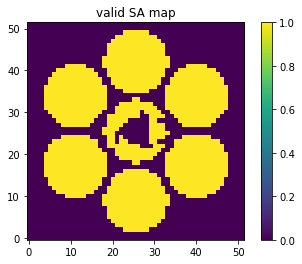

In [12]:
src.fwhm = DFT_osf * wfs.BIN_IMAGE #To sample at Shannon the sub-aperture DL spot.
wfs.calibrate(src, 0.65)

plt.imshow(wfs.valid_lenslet_mask, origin='lower', interpolation='None')
plt.colorbar();
plt.title('valid SA map');

#### Reference slope vector

The fininte differences computed directly from the wavefront map provides the *expected wavefront slopes*.

Note: The reference slope units are centroid location in pixels (distance from bottom left corner of sub-aperture).

Text(0.5, 1.0, 'Simulated')

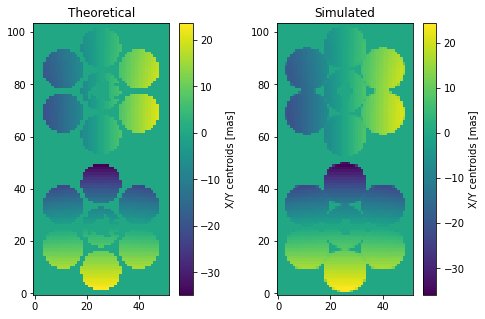

In [13]:
#-- Theoretical reference slopes
cxy = src._gs.wavefront.finiteDifference(wfs.N_SIDE_LENSLET, src._gs.rays.L / wfs.N_SIDE_LENSLET, 
                                         wfs.valid_lenslet)

#-- Actual calibrated reference slopes 
#-- units: raw centroid (distance from bottom left corner of sub-aperture) in pixels
CENTER_OF_SUBAP = (wfs.N_PX_SUBAP-1)/2
shmeas_ref = np.reshape(wfs.c0.host()-CENTER_OF_SUBAP, (wfs.N_SIDE_LENSLET*2, wfs.N_SIDE_LENSLET)) * wfs.pixel_scale

fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((8,5))
im1 = ax1.imshow(cxy.host(units='mas'), origin='lower', interpolation='None')
clb1 = fig.colorbar(im1, ax=ax1, label="X/Y centroids [mas]")
ax1.set_title("Theoretical")

im2 = ax2.imshow(shmeas_ref*constants.RAD2MAS, origin='lower', interpolation='None')
clb2 = fig.colorbar(im2, ax=ax2, label="X/Y centroids [mas]")
ax2.set_title("Simulated")

#### Set reference wavefront
We want to compute phase statistics after removing the reference wavefront.

In [14]:
wfpt.reset()
src.reset()

wfpt.propagate(src)
src.set_reference_wavefront()

## Apply commands to Active Mirrors and propagate wavefront
A state vector is defined containing the following degrees of freedom:
1. **M1_PTT**: 
    1. *segment piston*    (7)
    2. *segment tip-tilt*  (7x2)
2. **M2_PTT:** idem
3. **M1_DM:** 
    1. *actuators*      (292)
4. **M2_DM:** idem

In [15]:
print(wfpt.state)

{'M1_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M2_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M1_DM': {'actuators': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 

To apply a command you should:
1. Extract a copy of the state vector (can be done only once);
2. Modify the copy of the state vector as desired;
3. Update the WFPT model with the desired state vector.

In [16]:
wfpt.reset()

# Extract copy of state vector
state = wfpt.state

# Modify the state vector as desired
#state['M2_DM']['actuators'][150:155:2] = 0.5
state['M1_PTT']['segment tip-tilt'][0,0] = 1e-5

# Update the WFPT model with the desired state vector
wfpt.update(state)

Propagate WF

In [17]:
%%time
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()

wfs.reset()
wfs.propagate(src)
wfs.process()

CPU times: user 816 ms, sys: 356 ms, total: 1.17 s
Wall time: 1.17 s


on-axis WFE: 30.5 nm RMS
segment WFE: [79.3  0.   0.   0.   0.   0.   0. ]


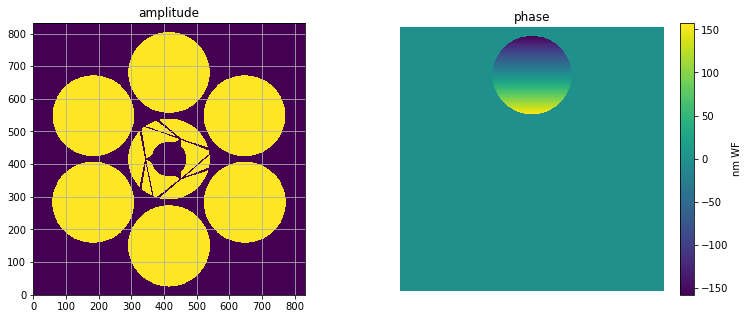

In [18]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))

ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_title('amplitude')
ax1.set_aspect('equal')
ax1.grid()

visu.show_wavefront((opd-opd0)*1e9, clb_label='nm WF', title='phase', fig=fig, ax=ax2)
print("on-axis WFE: %0.1f nm RMS"%(src.phaseRms()*1e9))

print("segment WFE:", np.array_str(src.phaseRms('segments')*1e9, precision=1, suppress_small=True))

### SH camera frame

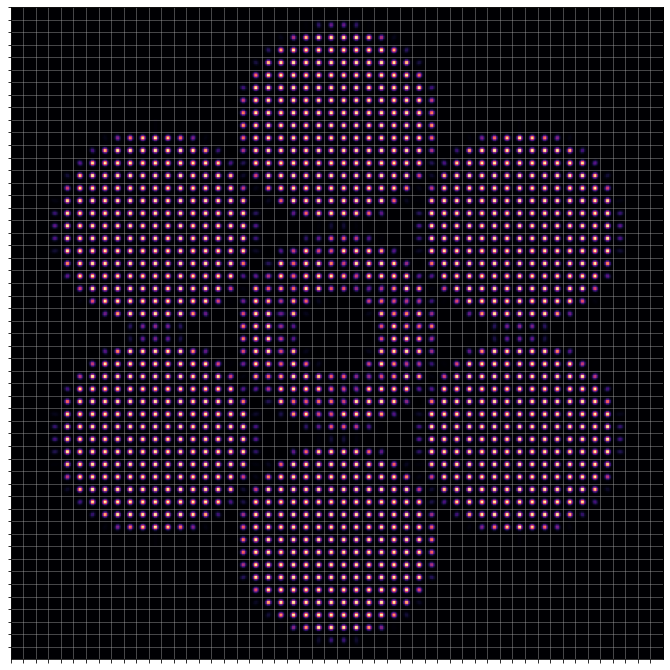

In [19]:
fig,ax = plt.subplots(figsize=(16,12))
ax.imshow(wfs.camera.frame.host(),cmap='magma')
ax.set_xticks(np.arange(0, wfs.N_PX_SUBAP*wfs.N_SIDE_LENSLET, wfs.N_PX_SUBAP)-0.5)
ax.set_yticks(np.arange(0, wfs.N_PX_SUBAP*wfs.N_SIDE_LENSLET, wfs.N_PX_SUBAP)-0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(alpha=0.5)

### SH measurements

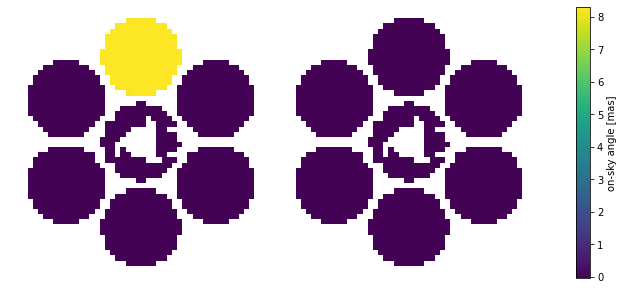

In [20]:
sx2d, sy2d = wfs.slopes2d()
visu.show_SH_slopes(sx2d*constants.RAD2MAS, sy2d*constants.RAD2MAS, clb_label='on-sky angle [mas]')

# Interaction Matrix Calibration

## M1 ALPAO zonal IFs - SH WFS

In [21]:
%%time
D_M1_ALPAO = wfpt.calibrate(wfs, src, mirror='M1', mode='actuators', stroke=0.1)

___ M1 ___ (actuators)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271

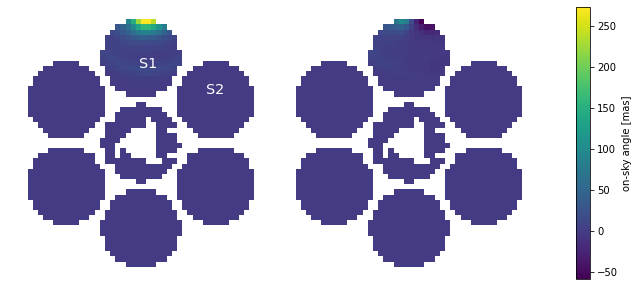

In [31]:
this_act = 1

slopevec = D_M1_ALPAO[:,this_act]
sx2d, sy2d = wfs.slopes2d(slopevec)

fig, ax = plt.subplots()
fig.set_size_inches((12,5))
visu.show_SH_slopes(sx2d*constants.RAD2MAS, sy2d*constants.RAD2MAS, clb_label='on-sky angle [mas]',
                   fig=fig, ax=ax)

ax.text(25,40,'S1',fontsize='x-large', color='white');
ax.text(38,35,'S2',fontsize='x-large', color='white');

## Reconstruction Matrix
Inverse of M1_DM-SH matrix

M1 DM - SH48 IM:
(2460, 292)
conditioning number:
532.0773247990003


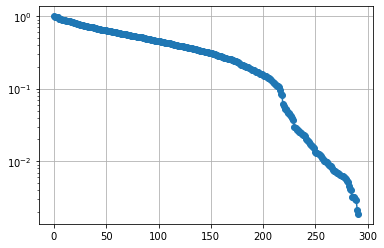

In [32]:
print('M1 DM - SH48 IM:')
print(D_M1_ALPAO.shape)
print("conditioning number:")
print(np.linalg.cond(D_M1_ALPAO))

UU1, ss1, VVT1 = np.linalg.svd(D_M1_ALPAO, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()

In [33]:
R_M1_ALPAO = np.linalg.pinv(D_M1_ALPAO)

### Test reconstructor

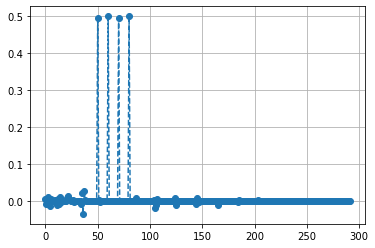

In [34]:
wfpt.reset()
state = wfpt.state
state['M1_DM']['actuators'][80] = 0.5
state['M1_DM']['actuators'][70] = 0.5
state['M1_DM']['actuators'][60] = 0.5
state['M1_DM']['actuators'][50] = 0.5

wfpt.update(state)

src.reset()
wfpt.propagate(src)
WFin = src._gs.phase.host()

wfs.reset()
wfs.propagate(src)
wfs.process()
sh_meas = wfs.get_measurement()

dm1_comm = R_M1_ALPAO @ sh_meas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(dm1_comm, 'o--')
plt.grid()

## M1 PTT array: Segment TT - SH WFS

In [35]:
%%time
D_M1_PTTarray_TT = wfpt.calibrate(wfs, src, mirror='M1', mode='segment tip-tilt', stroke=1e-5)

___ M1 ___ (segment tip-tilt)
Segment #:1 2 3 4 5 6 7 
------------
CPU times: user 22 s, sys: 11 s, total: 33 s
Wall time: 33 s


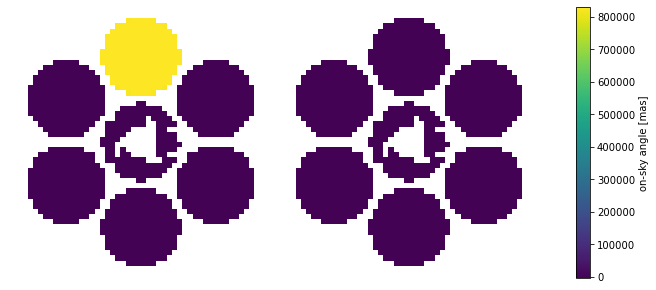

In [37]:
this_mode = 0
sx2d, sy2d = wfs.slopes2d(D_M1_PTTarray_TT[:,this_mode])
visu.show_SH_slopes(sx2d*constants.RAD2MAS, sy2d*constants.RAD2MAS, clb_label='on-sky angle [mas]')

# Perform a closed-loop test
The closed-loop demo below only controls the ALPAO DM actuators.

## Introduce a scramble

In [38]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

WFE: 439.1 nm RMS


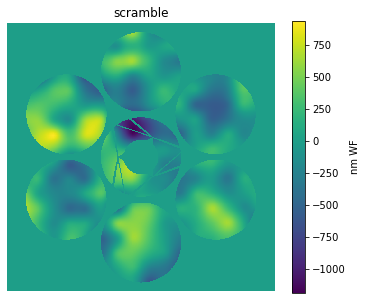

In [40]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
#state0['M1_DM']['actuators'][181] = 0.5
state0['M1_DM']['actuators'][:] = rng.standard_normal(size=wfpt.M1_DM.modes.n_mode)*0.05
wfpt.update(state0)

# Visualize the scramble
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()
print("WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))
visu.show_wavefront((opd-opd0)*1e9, clb_label='nm WF', title='scramble')

## Close the loop

In [42]:
totSimulIter = 30
gain = 0.2
tid = StopWatch()

M1_DM_comm_buffer = np.zeros(wfpt.M1_DM.modes.n_mode)
wfe_iter = np.zeros(totSimulIter)

In [43]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    src.reset()
    wfpt.propagate(src)
    #wfe_iter[jj] = src._gs.wavefront.rms()
    wfe_iter[jj] = src.phaseRms()
    
    #--- WFS measurements and command
    wfs.reset()
    wfs.propagate(src)
    wfs.process()
    measvec = wfs.get_measurement()
    M1_DM_delta_comm = R_M1_ALPAO @ measvec
    M1_DM_comm_buffer += gain * M1_DM_delta_comm
    
    #--- Update state vector
    state['M1_DM']['actuators'] = -M1_DM_comm_buffer
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1185.07, WFE [nm WF RMS] on-axis: 0.54

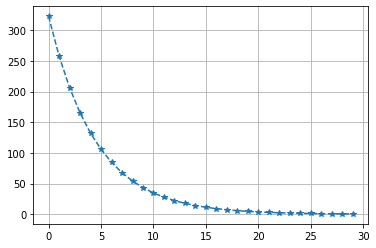

In [44]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()

WFE: 305.8 nm RMS


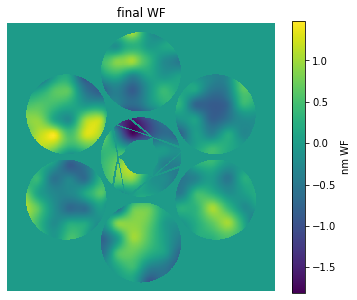

In [45]:
opd = src._gs.phase.host()

print("WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))
visu.show_wavefront((opd-opd0)*1e9, clb_label='nm WF', title='final WF')

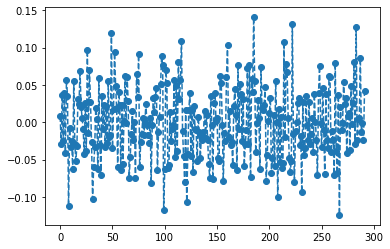

In [46]:
plt.plot(M1_DM_comm_buffer, 'o--')

# Additional characterizations

## Signal linearity as a function of FWHM of source

In [81]:
wfpt.reset()
src.reset()
wfs.reset()

TTin = np.arange(0,2.5e-3,1e-5)
niter = len(TTin)

In [82]:
slopes = []

for jj in range(niter):
    tid.tic()
    wfpt.reset()
    state = wfpt.state
    state['M1_PTT']['segment tip-tilt'][0,0] = TTin[jj]
    wfpt.update(state)
    
    src.reset()
    wfpt.propagate(src)
    wfs.reset()
    wfs.propagate(src)
    wfs.process()
    slopes += [np.abs(np.max(wfs.get_measurement()))]
    
    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f"%(jj, niter, tid.elapsedTime))
    sys.stdout.flush()

slopes = np.array(slopes)

 iter: 249/250, ET: 1178.08

(0.0, 1.5)

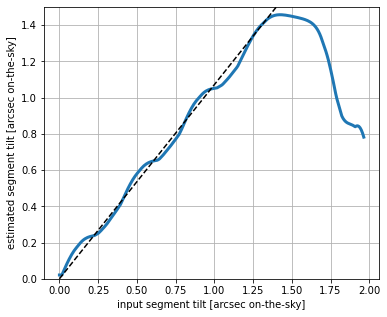

In [84]:
fig, ax = plt.subplots()
fig.set_size_inches((6,5))
ax.plot(2*TTin*constants.RAD2ARCSEC/wfpt._scale, slopes*constants.RAD2ARCSEC, linewidth=3)
ax.plot([0,1.4],[0,1.5], 'k--')
ax.grid()
ax.set_xlabel('input segment tilt [arcsec on-the-sky]')
ax.set_ylabel('estimated segment tilt [arcsec on-the-sky]')

ax.set_ylim([0,1.5])

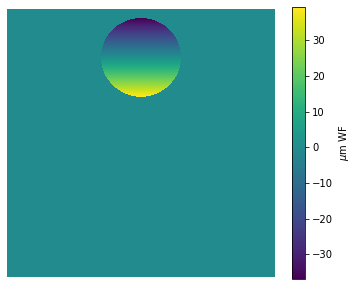

In [85]:
#-- show the last WF applied (i.e. max tilt amplitude)
opd = src._gs.phase.host()
visu.show_wavefront((opd-opd0)*1e6, clb_label='$\mu$m WF')

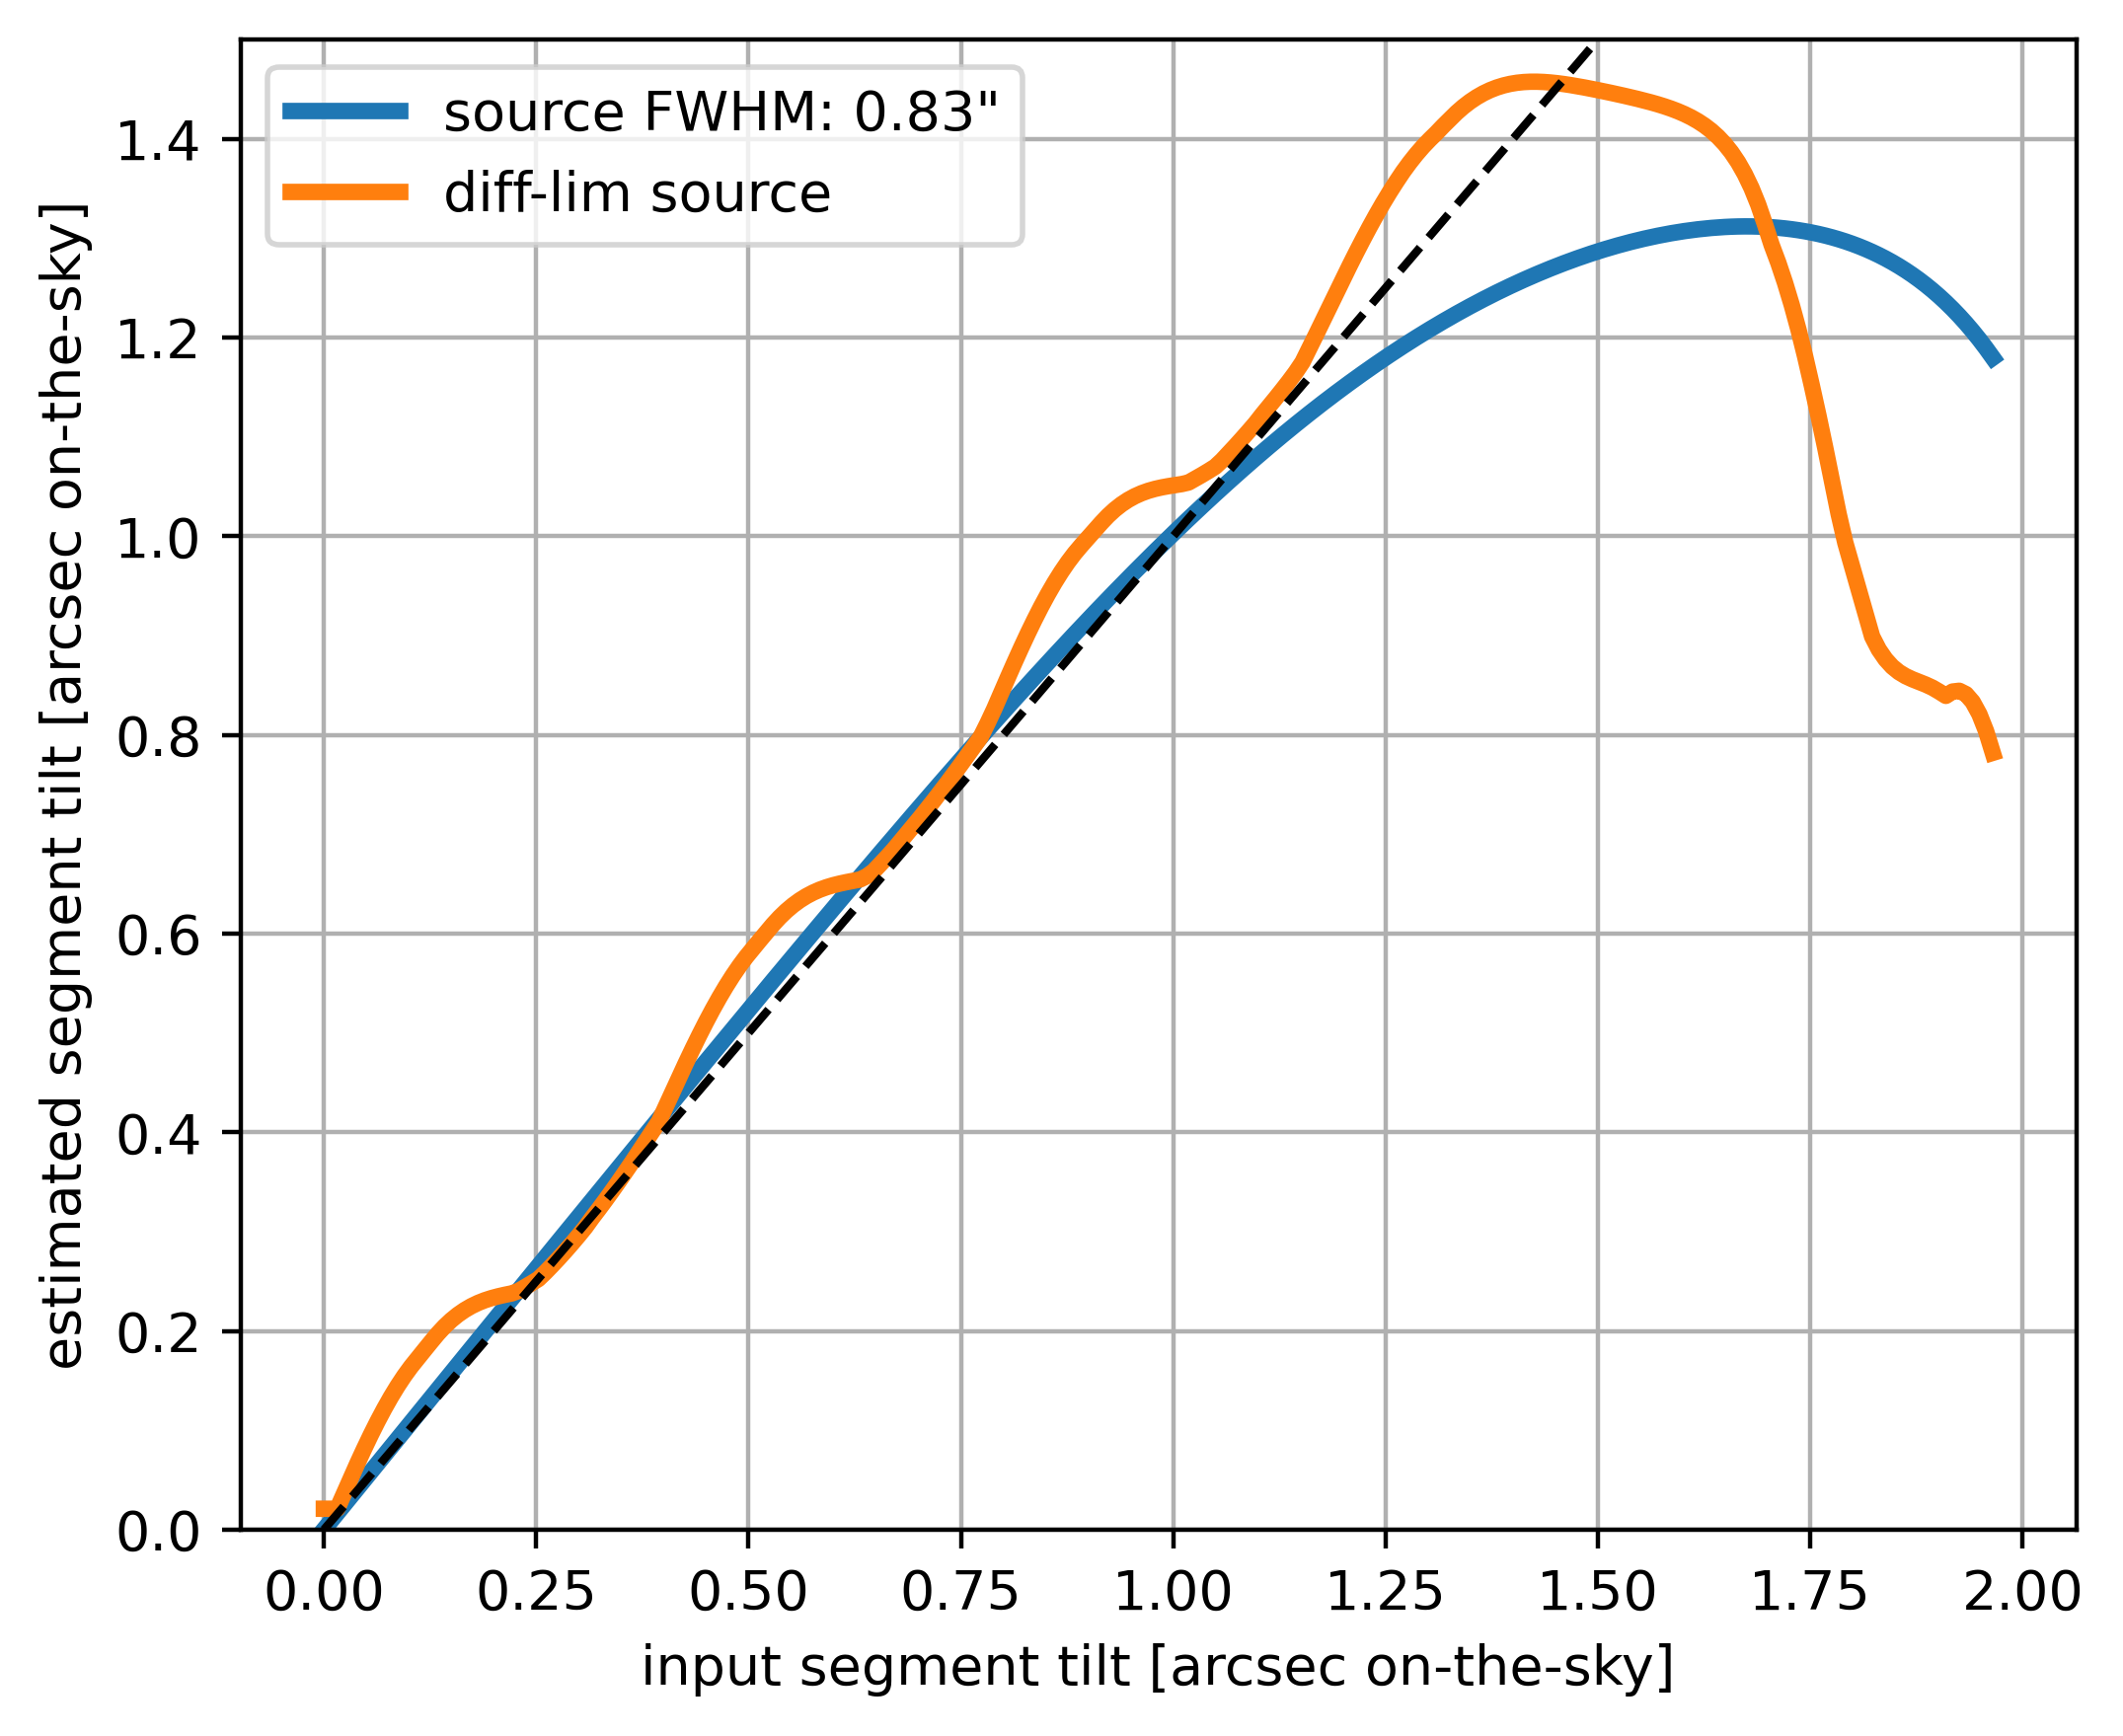

In [92]:
fig, ax = plt.subplots()
fig.set_size_inches((6,5))
fig.dpi = 400
ax.plot(sh_linearity_extsrc[0], sh_linearity_extsrc[1], linewidth=3, label='source FWHM: 0.83"')
ax.plot(sh_linearity_DLsrc[0], sh_linearity_DLsrc[1], linewidth=3, label='diff-lim source')
ax.plot([0,1.5],[0,1.5], 'k--')
ax.grid()
ax.set_xlabel('input segment tilt [arcsec on-the-sky]')
ax.set_ylabel('estimated segment tilt [arcsec on-the-sky]')

ax.set_ylim([0,1.5])
ax.legend()